In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

# Load datasets
df = pd.read_csv('/content/drive/MyDrive/fake_or_real_final (1).xls')

# Check the column names in the DataFrame
print(df.columns)

# Check unique values in the 'label' column
print(df['label'].unique())




# Split into features and labels
X = df['final_news']
y = df['label']

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Index(['Unnamed: 0', 'label', 'final_news'], dtype='object')
[0 1]


In [ ]:
if 'Unnamed: 0' in df.columns:
    df.drop(['Unnamed: 0'], axis=1, inplace=True)
else:
    print("Column 'Unnamed: 0' not found.")

In [ ]:
df.head()

,label,final_news
0,0,smell hillary s fear smell hillary s fear
1,0,watch exact moment paul ryan committed politic...
2,1,kerry go paris gesture sympathy kerry go paris...
3,0,bernie supporters twitter erupt anger dnc we...
4,1,battle new york primary matters battle new yo...


In [ ]:
# Vectorizing the text data using TF-IDF
vectorizer = TfidfVectorizer(max_features=10000, stop_words='english')
X_train_tfidf = vectorizer.fit_transform(X_train).toarray()
X_test_tfidf = vectorizer.transform(X_test).toarray()

# Check the shape of the data
print(X_train_tfidf.shape, X_test_tfidf.shape)


(5068, 8513) (1267, 8513)


In [45]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras import regularizers, models

# FNNet model architecture
from tensorflow.keras import regularizers

def fnnnet_model(input_dim):
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu', input_shape=(input_dim,), kernel_regularizer=regularizers.l2(0.01)))  # L2 regularization
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.01)))  # L2 regularization
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(1, activation='sigmoid'))
    return model



# Define model
fnnnet = fnnnet_model(X_train_tfidf.shape[1])

# Compile model
fnnnet.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Display model architecture
fnnnet.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_28 (Dense)                     │ (None, 64)                  │         320,064 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_29 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_15 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_30 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 322,177 (1.23 MB)

 Trainable params: 322,177 (1.23 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Function to preprocess and predict a single news article
def predict_news(news_text, model, vectorizer):
    # Preprocess and vectorize the input news text
    news_vectorized = vectorizer.transform([news_text]).toarray()

    # Predict whether the news is fake (0) or true (1)
    prediction = model.predict(news_vectorized)

    # Interpret the prediction
    if prediction >= 0.5:
        return "True News"
    else:
        return "Fake News"

# Example news to test
test_news = "The state government is nearing the final stages of selecting a site for Bengaluru's second international airport, with the location likely to be near Nelamangala. After thorough evaluation, the area between Nelamangala and Kunigal, along National Highway 75, has been identified as the most suitable for the new airport, according to sources."

# Call the prediction function
result = predict_news(test_news, fnnnet, vectorizer)
print(f"The news is: {result}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step
The news is: Fake News


In [49]:
import matplotlib.pyplot as plt

# Variables to store training and validation metrics
train_accuracies = []
train_losses = []
val_accuracies = []
val_losses = []

# Train for 500 epochs
epochs = 5

label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

history = fnnnet.fit(X_train_tfidf.toarray(), y_train, epochs=epochs, batch_size=64, validation_data=(X_test_tfidf.toarray(), y_test))


# Extract metrics from the history object
train_accuracies = history.history['accuracy']
train_losses = history.history['loss']
val_accuracies = history.history['val_accuracy']
val_losses = history.history['val_loss']

# Print metrics for each epoch
for epoch in range(epochs):
    print(f'Epoch {epoch + 1}/{epochs}')
    print(f'Train loss: {train_losses[epoch]:.4f}, Train accuracy: {train_accuracies[epoch]:.4f}')
    print(f'Validation loss: {val_losses[epoch]:.4f}, Validation accuracy: {val_accuracies[epoch]:.4f}')

Epoch 1/5
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.9140 - loss: 0.5219 - val_accuracy: 0.8122 - val_loss: 0.6649
Epoch 2/5
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.9099 - loss: 0.5124 - val_accuracy: 0.7877 - val_loss: 0.6760
Epoch 3/5
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9167 - loss: 0.5059 - val_accuracy: 0.7979 - val_loss: 0.6798
Epoch 4/5
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9185 - loss: 0.5069 - val_accuracy: 0.8074 - val_loss: 0.6733
Epoch 5/5
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9112 - loss: 0.5005 - val_accuracy: 0.8011 - val_loss: 0.6734
Epoch 1/5
Train loss: 0.5411, Train accuracy: 0.8966
Validation loss: 0.6649, Validation accuracy: 0.8122
Epoch 2/5
Train loss: 0.5372, Train accuracy: 0.8919
Validation loss: 0.6760, Validation accuracy: 0.7877
Epoch 3/5
Train loss: 0.5333, Train accuracy: 0.8960
Validation loss: 0.6798, Validation accuracy: 0.7979
Epoch 4/5
Train loss: 0.5252, Train accuracy: 0.9029
Va

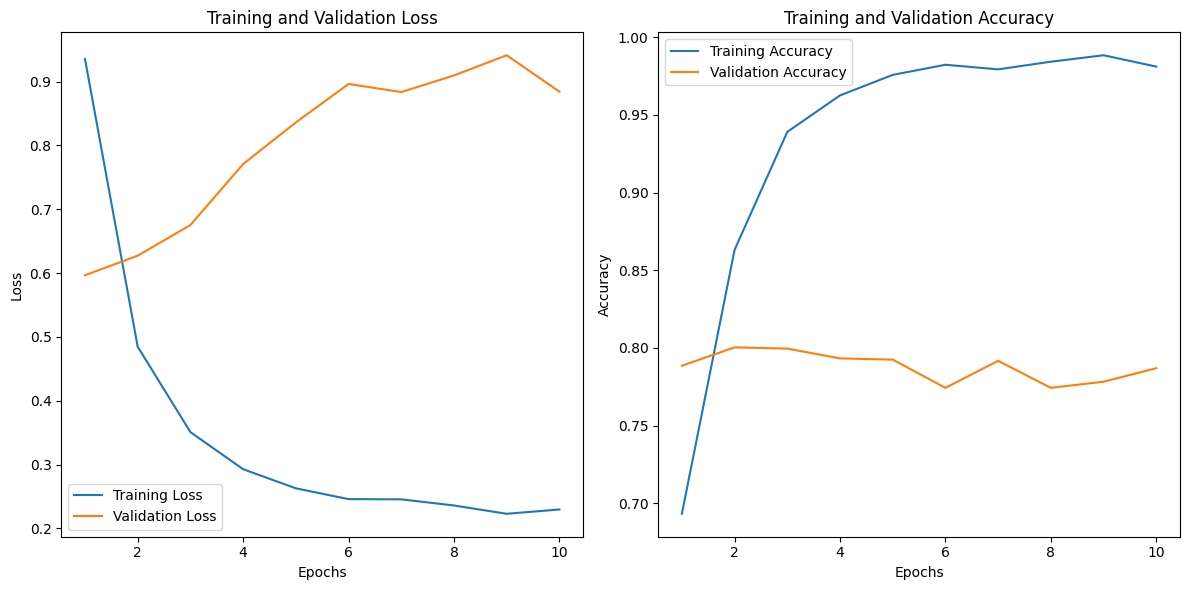

In [ ]:
# Plot the training and validation loss
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(range(1, epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs+1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, epochs+1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import classification_report
import numpy as np


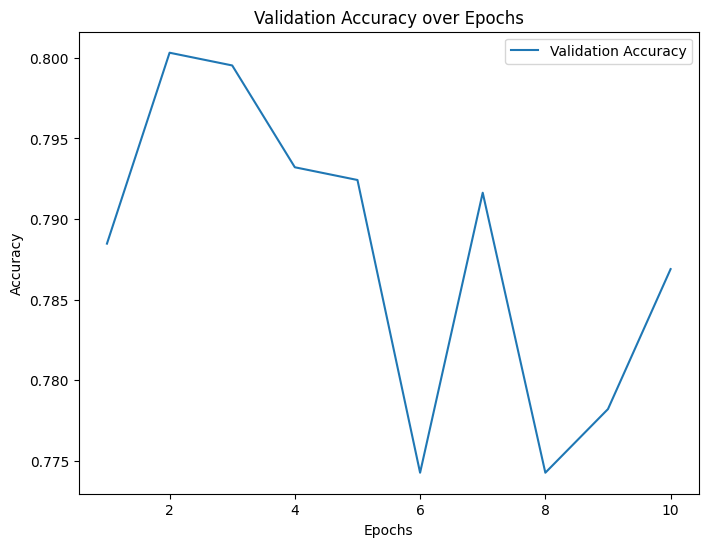

In [ ]:
# prompt: give the code for getting validation accuracy for the above model and show it graphically

# Plot the validation accuracy
plt.figure(figsize=(8, 6))
plt.plot(range(1, epochs+1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy over Epochs')
plt.legend()
plt.show()


In [ ]:
# prompt: take the input from the user and predict if the article given is true or fake from the trained model

# Get input from the user
user_input = input("Enter the news article: ")

# Call the prediction function
result = predict_news(user_input, fnnnet, vectorizer)
print(f"The news is: {result}")


Enter the news article: h
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
The news is: Fake News


In [ ]:
!pip install wordcloud

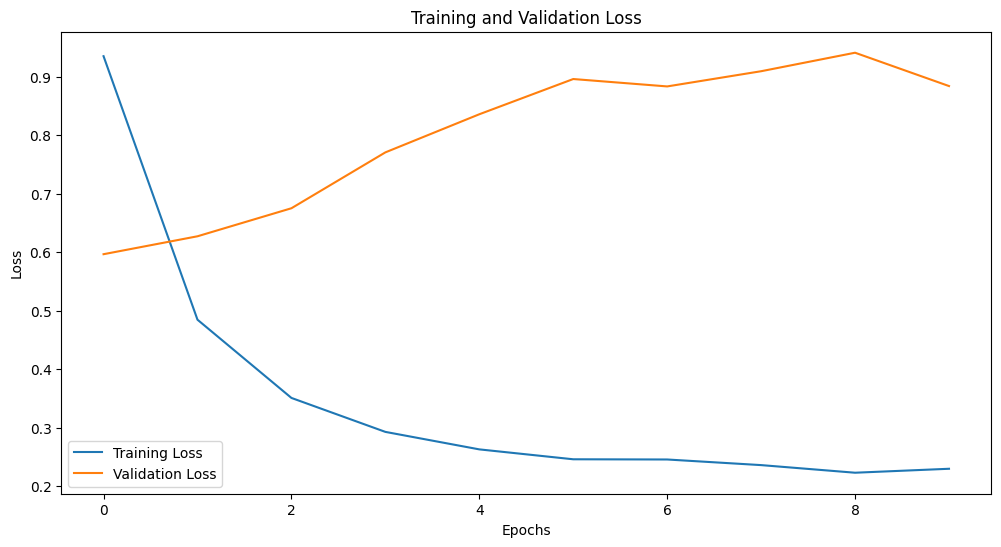

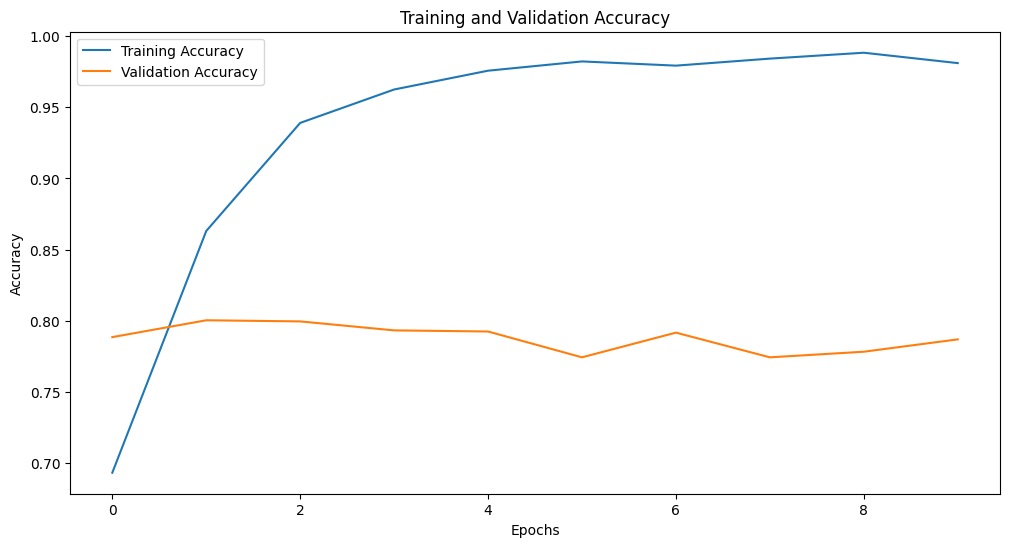

40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


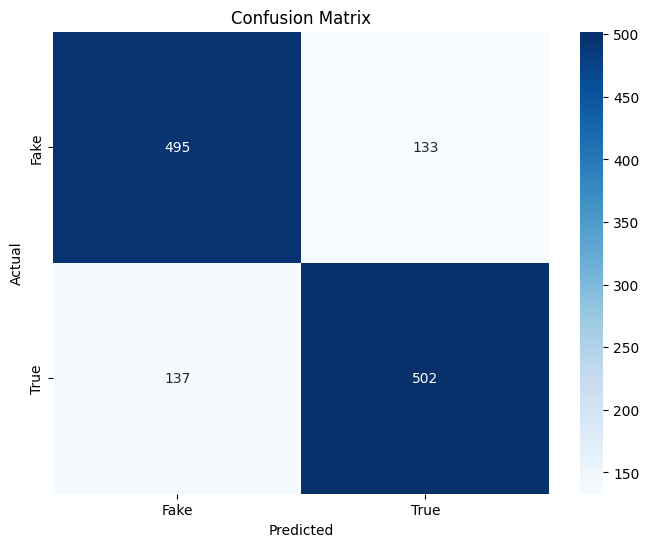

40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step


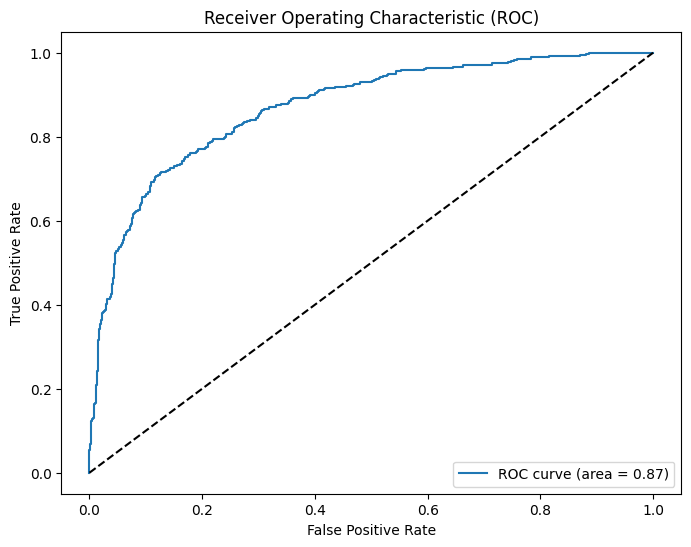

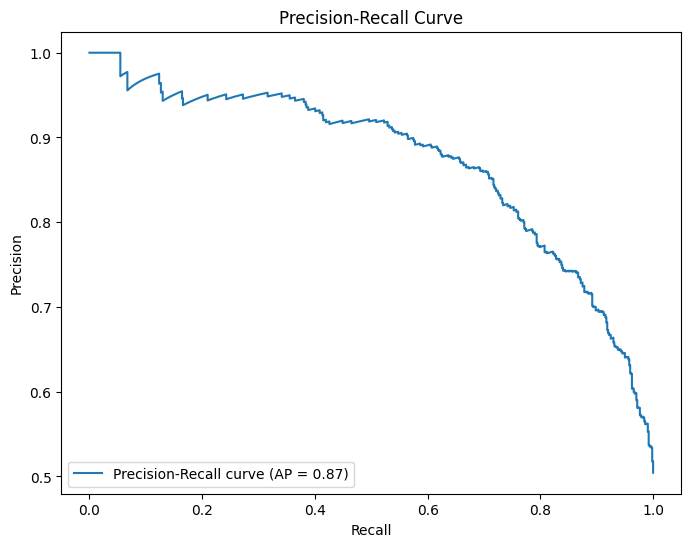

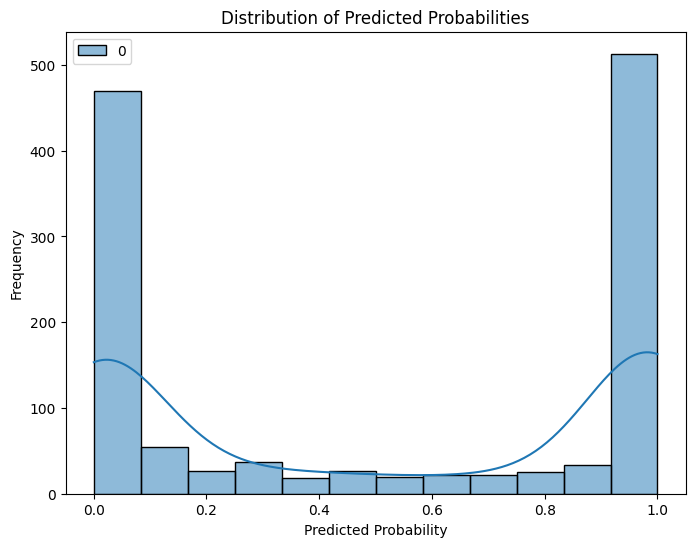

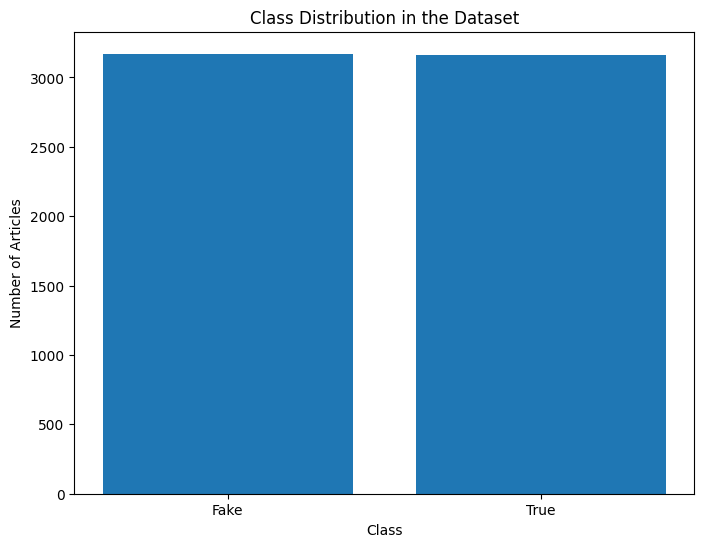

In [ ]:
# prompt: give all the codes for all the possible ways for visuals and graphs available for this model

import matplotlib.pyplot as plt
import seaborn as sns

# 1. Plot Training and Validation Loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# 2. Plot Training and Validation Accuracy
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

# 3. Plot Confusion Matrix (requires predictions on test data)
from sklearn.metrics import confusion_matrix

y_pred = (fnnnet.predict(X_test_tfidf) > 0.5).astype("int32")
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Fake', 'True'], yticklabels=['Fake', 'True'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# 4. Plot ROC Curve (requires predictions on test data)
from sklearn.metrics import roc_curve, auc

y_pred_proba = fnnnet.predict(X_test_tfidf)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # Random guess line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

# 5. Plot Precision-Recall Curve (requires predictions on test data)
from sklearn.metrics import precision_recall_curve, average_precision_score

precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
average_precision = average_precision_score(y_test, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label='Precision-Recall curve (AP = %0.2f)' % average_precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()

# 6. Distribution of Predicted Probabilities
plt.figure(figsize=(8, 6))
sns.histplot(y_pred_proba, kde=True)
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.title('Distribution of Predicted Probabilities')
plt.show()

# 7. Bar plot of class distribution in the dataset
class_counts = df['label'].value_counts()
plt.figure(figsize=(8, 6))
plt.bar(['Fake', 'True'], class_counts.values)
plt.xlabel('Class')
plt.ylabel('Number of Articles')
plt.title('Class Distribution in the Dataset')
plt.show()

# 8. Word Cloud (requires text preprocessing)
from wordcloud import WordCloud

# Combine all text from true news
true_text = ' '.join(df[df['label'] == 1]['final_news'].tolist())



40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
              precision    recall  f1-score   support

           0       0.78      0.79      0.79       628
           1       0.79      0.79      0.79       639

    accuracy                           0.79      1267
   macro avg       0.79      0.79      0.79      1267
weighted avg       0.79      0.79      0.79      1267



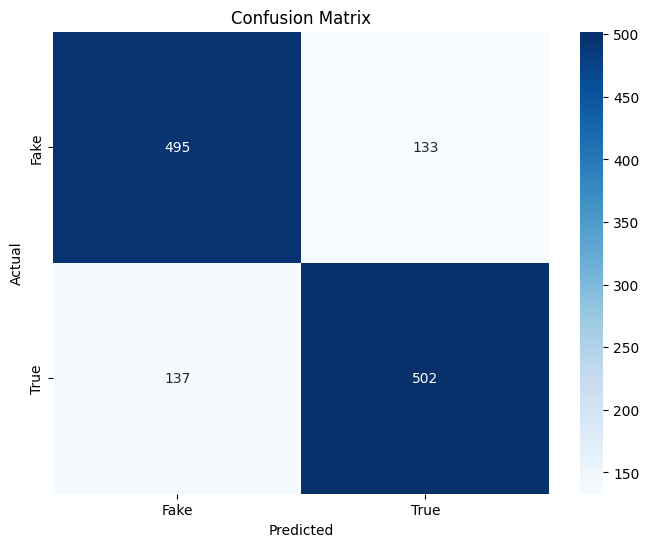

In [ ]:
# prompt: classification report and confusion matrix

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predict probabilities for the test set
y_pred_proba = fnnnet.predict(X_test_tfidf)

# Convert probabilities to class labels (0 or 1) using a threshold of 0.5
y_pred = (y_pred_proba > 0.5).astype("int32")

# Generate the classification report
report = classification_report(y_test, y_pred)
print(report)

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix using Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Fake', 'True'], yticklabels=['Fake', 'True'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
?????????????????

Object `???????????????` not found.
